# BONUS. The idea behind SVDLog

In [1]:
import embedded_voting as ev
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
np.random.seed(42)

In this notebook we are working again on the problem of algorithms aggregations. This time, we want to see why we can need sometimes the **SVDLog** rule, instead of **SVDNash**. For that, we will compare the different rules based on SVD.

In [2]:
list_rules = [ev.SVDNash(), ev.SVDSum(), ev.SVDLog(), ev.SumScores()]

def prodscal(a,b):
    return np.dot(a,b)
fake_rules = [ev.FakeSVDRule(aggregation_rule=np.prod, similarity=prodscal),
             ev.FakeSVDRule(aggregation_rule=np.sum, similarity=prodscal),
             ev.FakeSVDRule(aggregation_rule=lambda x: np.sum(np.log(1+x/1)), similarity=prodscal),
             ev.SumScores()]
list_names = ["SVDNash", "SVDSum", "SVDLog", "Sum"]

We create a score generator with $4$ dimensions and $5$ mixed groups

In [3]:
groups_sizes = []
features = []
for k in range(6):
    groups_sizes.append(np.random.randint(6)*5+1)
    features.append(np.random.randint(2, size=6))

In [4]:
groups_sizes

[16, 6, 16, 16, 1, 1]

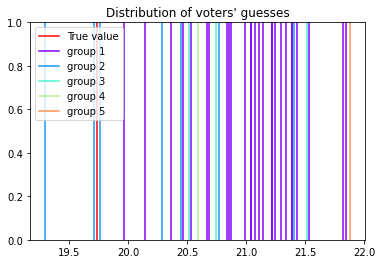

In [5]:
groups_sizes = [27, 7, 3, 1, 1]
features = [[1, 0, 0,0], [0, 1, 0,1], [1, 0, 1,0], [0, 1, 1,0], [0, 0, 1,1]]

generator = ev.GroupedMixGenerator(groups_sizes, features)
generator.set_group_noise(10)
generator.set_independent_noise(0.5)
generator.plot_scores()

In [6]:
n_voters = int(np.sum(groups_sizes))
n_candidates = 20

## Evolution with the number of dimensions

What we are doing here is that we are changing the number of dimensions used in the **AutoProfile**.

Indeed, if you use $n_{dim} = 0$, the profile automatically infer the number of dimensions with *scikit-learn*, but you can also specify the number of dimension. If you need to that, you might know that **SVDNash** and other rules do note perform the same depending on the number of dimensions used.

In [11]:
def dim_evolution(training_size=100):
    results = []
    
    dims = np.arange(1,21)
    for dim in dims:
            
        truth, scores = generator.sample_scores(20)
        _, training = generator.sample_scores(training_size)

        # We get the real welfare of each candidate using a SumScoresProfile 
        true_profile = ev.Profile(n_candidates, 0)
        true_profile.add_voter([], truth)
        target = ev.SumScores(true_profile)
        welfare = target.welfare_

        # We create the profile of voters-algorithms
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_auto(scores, training, n_dim=dim)

        # We get the preformance of every rule
        results_i = []
        for rule in list_rules:
            w = rule(profile).winner_
            results_i.append(welfare[w])

        results.append(results_i)

    results = np.array(results).T
    return results

In [12]:
results = np.zeros((len(list_rules), 20))

n_trys = 500
for i in tqdm(range(n_trys)):
    results += dim_evolution()

results = results/n_trys

100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


As you can see on the following figure, **SVDNash** works well when the correct number of dimension is inferred (here $4$), with a small margin of error. But, if the number of dimensions used is higher ($> 10$ for instance), then **SVDNash** is not as efficient, and its welfare is close to the welfare of **SVDSum**. However, **SVDLog**'s welfare is still as high as before.

In summary, **SVDLog** is a bit less good when we have the correct number of dimension, but it's performance is stable when the number of dimensions change!

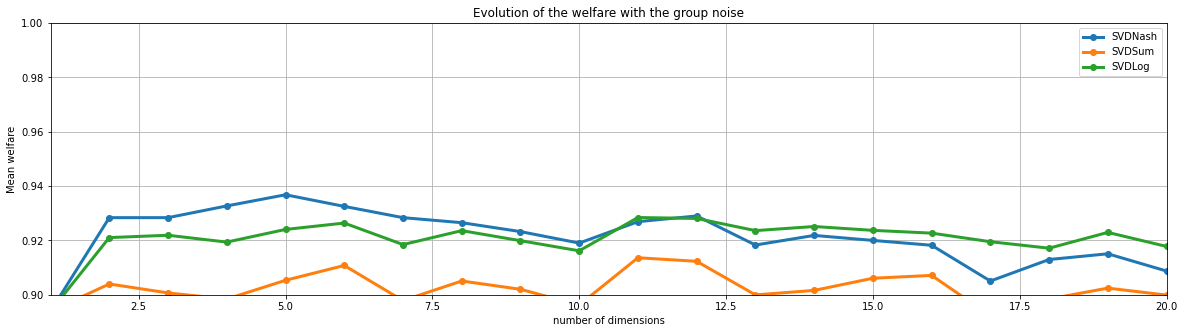

In [13]:
tab_dims = np.arange(1,21)

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_dims, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.9, 1)
plt.xlim(1,20)
plt.legend()
plt.xlabel("number of dimensions")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with the group noise")
plt.grid(0.3)
plt.legend()
plt.show()

## What happen if we take the full matrix of covariance?

Let's compare what we got if we do not use PCA at all and directly use the covariance matrix, which is more elegant.

In [28]:

def transform_score(s):
    return np.exp((s - np.mean(s))/np.std(s))


def best_method(training_size=100):
    results = []
               
    truth, scores = generator.sample_scores(20)
    _, training = generator.sample_scores(training_size)

    # We get the real welfare of each candidate using a SumScoresProfile 
    true_profile = ev.Profile(n_candidates, 0)
    true_profile.add_voter([], truth)
    target = ev.SumScores(true_profile)
    welfare = target.welfare_

    results = np.zeros((9, len(list_rules)))
    
    """
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_cov(scores, training, normalize_score=True)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[0,i] = welfare[w]
        
    """
    
    #print(""" PCA True, True""")
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_auto(scores, training, normalize_score=True, normalize_embs=True)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[0,i] = welfare[w]
        
    
    #print(""" PCA True, False""")
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_auto(scores, training, normalize_score=True, normalize_embs=False)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[1,i] = welfare[w]
        
        
    #print(""" PCA Full True, True""")
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_auto(scores, training, generator.n_voters, normalize_score=True, normalize_embs=True)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[2,i] = welfare[w]
    

        
    #print(""" PCA Full True, False""")
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_auto(scores, training, generator.n_voters, normalize_score=True, normalize_embs=False)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[3,i] = welfare[w]
    

    #print(""" Prods""")
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_prod(scores, training, normalize_score=True)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[4,i] = welfare[w]
        

        
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_fake(scores, training)
    w = ev.NoPCA(profile, lambda x: x/np.linalg.norm(x)).winner_
    
    results[5,0] = welfare[w]
    
        
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_fake(scores, training)
    w = ev.NoPCA(profile, transform_score).winner_
    results[6,0] = welfare[w]
    
    
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_fake(scores, training)
    w = ev.NoPCA(profile, lambda x: np.sqrt(np.maximum(0,x/np.linalg.norm(x)))).winner_
    
    results[7,0] = welfare[w]
    
        
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_fake(scores, training)
    w = ev.NoPCA(profile, lambda x: np.sqrt(np.maximum(0,transform_score(x)))).winner_
    results[8,0] = welfare[w]
        
             
    return results

In [29]:
results = []

n_trys = 200
for _ in tqdm(range(n_trys)):
    results.append(best_method())

results = np.array(results)


100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


As you can see in the following table, **SVDLog** performs better than the other rules with the full matrix. However, for any rule, doing the **PCA** is far better than using the full matrix.

In [30]:
display(pd.DataFrame(results.mean(axis=0), columns=list_names, index=["pca 1", "pca 0","pca full 1","pca full 0", "prod","fanfan", "fanfan exp", "fanfan sqrt", "fanfan sqrt exp"]))
display(pd.DataFrame(results.std(axis=0), columns=list_names, index=["pca 1", "pca 0","pca full 1","pca full 0", "prod","fanfan", "fanfan exp", "fanfan sqrt", "fanfan sqrt exp"]))

,SVDNash,SVDSum,SVDLog,Sum
pca 1,0.944174,0.901268,0.925711,0.887287
pca 0,0.941527,0.878578,0.942072,0.887287
pca full 1,0.896822,0.901268,0.924947,0.887287
pca full 0,0.896822,0.878578,0.896822,0.887287
prod,0.896822,0.887287,0.896822,0.887287
fanfan,0.941527,0.000000,0.000000,0.000000
fanfan exp,0.938413,0.000000,0.000000,0.000000
fanfan sqrt,0.941527,0.000000,0.000000,0.000000
fanfan sqrt exp,0.940250,0.000000,0.000000,0.000000


,SVDNash,SVDSum,SVDLog,Sum
pca 1,0.076320,0.126863,0.099174,0.149618
pca 0,0.082848,0.156349,0.082749,0.149618
pca full 1,0.129376,0.126863,0.099093,0.149618
pca full 0,0.129376,0.156349,0.129376,0.149618
prod,0.129376,0.149618,0.129376,0.149618
fanfan,0.082848,0.000000,0.000000,0.000000
fanfan exp,0.085602,0.000000,0.000000,0.000000
fanfan sqrt,0.082848,0.000000,0.000000,0.000000
fanfan sqrt exp,0.084128,0.000000,0.000000,0.000000


In [8]:
truth, scores = generator.sample_scores(20)
_, training = generator.sample_scores(100)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=training.shape[0])
projection_matrix = pca.fit_transform(training.T)
print(projection_matrix.shape)
embs = training.dot(projection_matrix)
print(embs)

(100, 39)
[[ 8.42219069e+03  4.36378698e+02 -2.77638608e+01 ... -1.81071802e-01
   2.12056054e+00 -8.88011775e-01]
 [ 8.43712830e+03  4.21598755e+02 -4.67359111e+01 ...  1.65405970e+00
   1.89548743e+00  6.98027283e-01]
 [ 8.72559568e+03  4.64940749e+02 -4.42973994e+01 ...  5.34244367e-01
  -1.95186559e+00  4.14871625e-01]
 ...
 [ 7.32238847e+03 -3.63565862e+02  4.98374924e+02 ... -1.21213776e+00
   2.72445217e-01  3.67605816e-01]
 [ 5.58208092e+03 -1.66390452e+03  5.02343058e+02 ...  9.90837886e-01
  -3.91973761e-01 -1.99647990e-01]
 [ 5.91072277e+03 -1.37009481e+03  3.95026392e+02 ...  9.00306891e-01
  -3.06284994e-01 -2.95418806e-01]]


In [10]:
prodscal = np.dot(training, training.T)
print(prodscal)

[[23650.32989333 23616.90207252 23775.02024215 ... 23371.95454771
  23130.63883641 22872.31013493]
 [23616.90207252 23632.13310702 23760.61181993 ... 23355.81844913
  23112.09044085 22870.25735959]
 [23775.02024215 23760.61181993 23939.97833881 ... 23494.39328588
  23238.15756809 22983.43699385]
 ...
 [23371.95454771 23355.81844913 23494.39328588 ... 23489.38080331
  23443.4922879  23105.95746334]
 [23130.63883641 23112.09044085 23238.15756809 ... 23443.4922879
  23911.7052871  23246.94082001]
 [22872.31013493 22870.25735959 22983.43699385 ... 23105.95746334
  23246.94082001 23087.03943308]]


In [11]:
u, s, v = np.linalg.svd(training)
s = np.diag(s)
udots = u.dot(s)
print(udots.dot(udots.T))

[[23650.32989333 23616.90207252 23775.02024215 ... 23371.95454771
  23130.63883641 22872.31013493]
 [23616.90207252 23632.13310702 23760.61181993 ... 23355.81844913
  23112.09044085 22870.25735959]
 [23775.02024215 23760.61181993 23939.97833881 ... 23494.39328588
  23238.15756809 22983.43699385]
 ...
 [23371.95454771 23355.81844913 23494.39328588 ... 23489.38080331
  23443.4922879  23105.95746334]
 [23130.63883641 23112.09044085 23238.15756809 ... 23443.4922879
  23911.7052871  23246.94082001]
 [22872.31013493 22870.25735959 22983.43699385 ... 23105.95746334
  23246.94082001 23087.03943308]]


In [12]:
train_bis = np.dot(udots,v[:39, :])

In [14]:
print(training.dot(v[:5,:].T).shape)

(39, 5)
